In [1]:
from itertools import product
import pandas as pd
import seaborn as sns

## Recovery with addm.tooldbox.ddm_pta_test

In [2]:
from __future__ import absolute_import, division

import pkg_resources

from builtins import range, str

from addm_toolbox.ddm import DDMTrial, DDM
from addm_toolbox.util import load_trial_conditions_from_csv

In [3]:
d = .006
sigma = .08
rangeD = [0.005, 0.006, 0.007]
rangeSigma = [0.065, 0.08, 0.095]
trialsFileName=None
trialsPerCondition=500 
numThreads = 9
verbose = False

In [4]:
def main(d, sigma, rangeD, rangeSigma, trialsFileName=None,
         trialsPerCondition=800, numThreads=9, verbose=False):
    """
    Args:
      d: float, DDM parameter for generating artificial data.
      sigma: float, DDM parameter for generating artificial data.
      rangeD: list of floats, search range for parameter d.
      rangeSigma: list of floats, search range for parameter sigma.
      trialsFileName: string, path of trial conditions file.
      trialsPerCondition: int, number of artificial data trials to be
          generated per trial condition.
      numThreads: int, size of the thread pool.
      verbose: boolean, whether or not to increase output verbosity.
    """
    # Load trial conditions.
    if not trialsFileName:
        trialsFileName = pkg_resources.resource_filename(
            u"addm_toolbox", u"test_data/test_trial_conditions.csv")
    trialConditions = load_trial_conditions_from_csv(trialsFileName)

    # Generate artificial data.
    model = DDM(d, sigma)
    trials = list()
    for (valueLeft, valueRight) in trialConditions:
        for t in range(trialsPerCondition):
            try:
                trials.append(model.simulate_trial(valueLeft, valueRight))
            except:
                print(u"An exception occurred while generating artificial "
                      "trial " + str(t) + u" for condition (" +
                      str(valueLeft) + u", " + str(valueRight) + u").")
                raise

    # Get likelihoods for all models and all artificial trials.
    numModels = len(rangeD) * len(rangeSigma)
    likelihoods = dict()
    models = list()
    posteriors = dict()
    for d in rangeD:
        for sigma in rangeSigma:
            model = DDM(d, sigma)
            if verbose:
                print(u"Computing likelihoods for model " + str(model.params) +
                      u"...")
            try:
                likelihoods[model.params] = model.parallel_get_likelihoods(
                    trials, numThreads=numThreads)
            except:
                print(u"An exception occurred during the likelihood "
                      "computations for model " + str(model.params) + u".")
                raise
            models.append(model)
            posteriors[model.params] = 1 / numModels

    # Compute the posteriors.
    for t in range(len(trials)):
        # Get the denominator for normalizing the posteriors.
        denominator = 0
        for model in models:
            denominator += (posteriors[model.params] *
                            likelihoods[model.params][t])
        if denominator == 0:
            continue

        # Calculate the posteriors after this trial.
        for model in models:
            prior = posteriors[model.params]
            posteriors[model.params] = (likelihoods[model.params][t] *
                prior / denominator)

    if verbose:
        for model in models:
            print(u"P" + str(model.params) +  u" = " +
                  str(posteriors[model.params]))
        print(u"Sum: " + str(sum(list(posteriors.values()))))
        
    return trials, models, likelihoods, posteriors

In [5]:
trials, models, likelihoods, posteriors = main(d, sigma, rangeD, rangeSigma, trialsFileName=None,
                                                  trialsPerCondition=500, numThreads=9, verbose=False)

What do the sum of the likelihoods for all 8000 (800 trials per condition for 10 conditions) look like for each parameter combination?

Do the true parameters (d = .006, sigma = .08) have the highest likelihood? No.

In [6]:
df = pd.DataFrame(list(product(rangeD, rangeSigma)), columns=['d', 'sigma'])
df['likelihood'] = [sum(likelihoods[k]) for k in likelihoods.keys()]
df

,d,sigma,likelihood
0,0.005,0.065,18.368466
1,0.005,0.080,19.156619
2,0.005,0.095,19.315669
3,0.006,0.065,20.485139
4,0.006,0.080,20.857850
5,0.006,0.095,20.667828
6,0.007,0.065,22.239266
7,0.007,0.080,22.282567
8,0.007,0.095,21.807858


Likelihood surface heatmap

<AxesSubplot:xlabel='sigma', ylabel='d'>

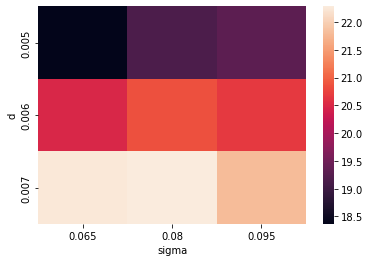

In [7]:
df = df.pivot(index = 'd', columns = 'sigma', values = 'likelihood')
sns.heatmap(df)

What do the posteriors look like?

Is the posterior higghest for the correct parameter combination? (d = 0.006, sigma = .08)

In [8]:
df = pd.DataFrame(list(product(rangeD, rangeSigma)), columns=['d', 'sigma'])
df['posterior'] = [posteriors[k] for k in posteriors.keys()]
df

,d,sigma,posterior
0,0.005,0.065,1.057751e-216
1,0.005,0.080,2.729293e-13
2,0.005,0.095,3.132604e-175
3,0.006,0.065,5.313764e-207
4,0.006,0.080,1.000000e+00
5,0.006,0.095,2.630618e-162
6,0.007,0.065,1.987215e-281
7,0.007,0.080,1.832994e-43
8,0.007,0.095,2.116324e-188


<AxesSubplot:xlabel='sigma', ylabel='d'>

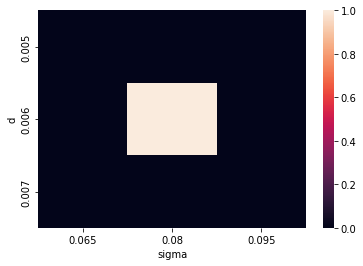

In [9]:
df = df.pivot(index = 'd', columns = 'sigma', values = 'posterior')
sns.heatmap(df)